In [69]:
import torch
from covid_ode import sidartha_ode, covid_dataset
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
canada = pd.read_csv('canada.csv')
canada = canada.values[:, 0:3].astype(float)

In [71]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
canada.shape

(555, 3)

In [73]:
canada

array([[4.000000e+00, 0.000000e+00, 0.000000e+00],
       [4.000000e+00, 0.000000e+00, 0.000000e+00],
       [4.000000e+00, 0.000000e+00, 0.000000e+00],
       ...,
       [1.435683e+06, 1.404327e+06, 2.660200e+04],
       [1.437713e+06, 1.405529e+06, 2.660800e+04],
       [1.438806e+06, 1.405971e+06, 2.661900e+04]])

In [74]:
TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(canada[:TRAIN_IDX])

MinMaxScaler()

In [75]:
canada_train = min_max_scaler.transform(canada[:TRAIN_IDX])
canada_val = min_max_scaler.transform(canada[TRAIN_IDX:VAL_IDX])
canada_test = min_max_scaler.transform(canada[VAL_IDX:])

In [76]:
# Learning Rate
lr = 0.0001

# number of historic data points for fitting
input_steps = 1

# forecasting horizon
output_steps = 2

# number of epochs for training
num_epochs = 50
num_epochs_for_test = 3

In [77]:
VAL_IDX-TRAIN_IDX

55

In [78]:
training_data = covid_dataset.CovidDataset(canada_train, input_steps, output_steps)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

val_data = covid_dataset.CovidDataset(canada_val, input_steps, output_steps)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

test_data = covid_dataset.CovidDataset(canada_test, input_steps, output_steps)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [79]:
def train(dataloader, limit=None):
    for i, data_with_exact in tqdm(enumerate(dataloader), total=limit if limit else len(train_dataloader)):
        losses = 0
        data, y_exact = data_with_exact
        optimizer.zero_grad()    
        y_approx = model(D0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
        loss = loss_fun(y_approx[1:, 
                                 [model.pos_dict['D'], model.pos_dict['H'], model.pos_dict['E']]], # D, H, E
                        y_exact.squeeze())
        loss.backward()
        losses += loss
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            state_dict = model.state_dict()
            for k in state_dict.keys():
                state_dict[k] = torch.clamp(state_dict[k], min=1e-2)
            model.load_state_dict(state_dict)
        if limit and i == limit:
            break
    print("Train losses:", losses/i)

In [80]:
model = sidartha_ode.SIDARTHEOde(len_data = output_steps).to(device)

torch.manual_seed(3407)
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.9)
loss_fun = torch.nn.MSELoss()

for _ in range(num_epochs):
    train(train_dataloader)
    if (_ % 10) == 0:
        validation_prediction = []
        with torch.no_grad():
            val_losses = 0
            for data, y_exact in val_dataloader:
                y_approx = model(D0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
                validation_prediction.append(y_approx.numpy())
                loss = loss_fun(y_approx[1:, 
                                     [model.pos_dict['D'], model.pos_dict['H'], model.pos_dict['E']]], # I, H, E
                            y_exact.squeeze())
                val_losses += loss
            print("Val losses: ", val_losses/len(val_data))

  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0114e-05, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0179)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.2045e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.2431e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.2294e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1483e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0538e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(9.5467e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(8.7583e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(7.8915e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(7.0654e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(6.3586e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0090)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.7203e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.1115e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.5398e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.1204e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.6593e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.2375e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.8517e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.5537e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.2656e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.9986e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0029)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.7945e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.5885e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.3999e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.2282e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1018e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(9.7107e-07, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(9.4974e-07, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0256e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0804e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1122e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0016)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1315e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1500e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1535e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1534e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1511e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1563e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1514e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1463e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1417e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1419e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0016)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1387e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1353e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1394e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1356e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1319e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1282e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1312e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1276e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.1240e-06, grad_fn=<DivBackward0>)


In [81]:
# predict, confirmed, recovered, death
validation_prediction = np.array(validation_prediction)
observerable=[validation_prediction[:, :, [model.pos_dict['D'], model.pos_dict['H'], model.pos_dict['E']]]]

In [82]:
inversed_predict = [min_max_scaler.inverse_transform(i) for i in observerable[0]]

In [83]:
inversed_predict = np.array(inversed_predict)

In [84]:
predict_1_ahead = inversed_predict[:,1]
predict_2_ahead = inversed_predict[:,2]

In [85]:
true_value=min_max_scaler.inverse_transform(canada_val)

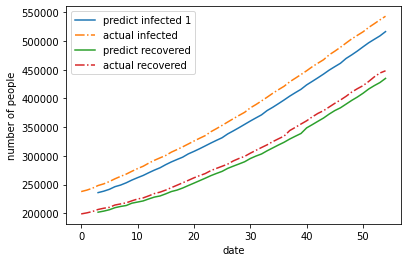

In [86]:
import matplotlib.pyplot as plt

x = range(len(true_value))

plt.plot(x[3:], predict_1_ahead[:,0], label ='predict infected 1')
plt.plot(x, true_value[:,0], '-.', label ='actual infected')
plt.plot(x[3:], predict_1_ahead[:,1], label ='predict recovered')
plt.plot(x, true_value[:,1], '-.', label ='actual recovered')

plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

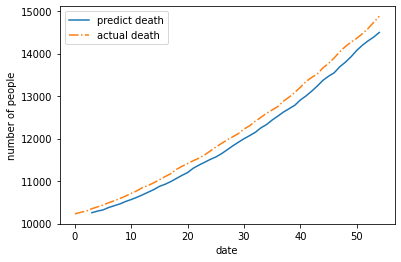

In [87]:
plt.plot(x[3:], predict_1_ahead[:,2], label ='predict death')
plt.plot(x, true_value[:,2], '-.', label ='actual death')
plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

In [88]:
mean_squared_error(predict_1_ahead[:,0], true_value[3:,0], squared=False)

21788.12751024525

In [89]:
mean_squared_error(predict_1_ahead[:,1], true_value[3:,1], squared=False)

10498.449974516981

In [90]:
mean_squared_error(predict_1_ahead[:,2], true_value[3:,2], squared=False)

241.75379541962772

### Predict whole test set

In [92]:
train(val_dataloader, limit=len(val_dataloader))

  0%|          | 0/52 [00:00<?, ?it/s]

Train losses: tensor(5.3822e-05, grad_fn=<DivBackward0>)


In [93]:
test_prediction = []
model_params = []
for i, data_and_output in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    data, _ = data_and_output
    # use test set prior to this step to retrain model
    if i % (output_steps+input_steps) == 0 and i > 0:
        print("Retrain on past test")
        for epoch in range(num_epochs_for_test):
            train(test_dataloader, limit=i-output_steps-1)  # only train on 1-output_steps-1 sample
    # predict
    with torch.no_grad():
        y_approx = model(D0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
        test_prediction.append(y_approx[1:,
                                        [model.pos_dict['D'], model.pos_dict['H'], model.pos_dict['E']]].detach().numpy())
        
    model_params.append([x.data for x in list(model.parameters())])

  0%|          | 0/220 [00:00<?, ?it/s]

Retrain on past test


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.9180e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.5368e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.2393e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0008, grad_fn=<DivBackward0>)


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0008, grad_fn=<DivBackward0>)


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0008, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(7.7996e-05, grad_fn=<DivBackward0>)


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(7.7059e-05, grad_fn=<DivBackward0>)


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(7.6127e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(7.2465e-05, grad_fn=<DivBackward0>)


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(7.1467e-05, grad_fn=<DivBackward0>)


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(7.0474e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(6.2610e-05, grad_fn=<DivBackward0>)


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(6.1676e-05, grad_fn=<DivBackward0>)


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(6.0749e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(5.1653e-05, grad_fn=<DivBackward0>)


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(5.0730e-05, grad_fn=<DivBackward0>)


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(4.9814e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(4.9408e-05, grad_fn=<DivBackward0>)


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(4.8498e-05, grad_fn=<DivBackward0>)


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(4.7675e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(3.3376e-05, grad_fn=<DivBackward0>)


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(3.2675e-05, grad_fn=<DivBackward0>)


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(3.1980e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(3.8688e-05, grad_fn=<DivBackward0>)


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(3.7911e-05, grad_fn=<DivBackward0>)


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(3.7140e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(3.2038e-05, grad_fn=<DivBackward0>)


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(3.1430e-05, grad_fn=<DivBackward0>)


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(3.0829e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(2.7854e-05, grad_fn=<DivBackward0>)


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(2.7233e-05, grad_fn=<DivBackward0>)


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(2.6622e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(3.0832e-05, grad_fn=<DivBackward0>)


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(3.0228e-05, grad_fn=<DivBackward0>)


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(2.9635e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(1.9879e-05, grad_fn=<DivBackward0>)


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(1.9365e-05, grad_fn=<DivBackward0>)


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(1.8871e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(2.3664e-05, grad_fn=<DivBackward0>)


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(2.3132e-05, grad_fn=<DivBackward0>)


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(2.2615e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(2.2307e-05, grad_fn=<DivBackward0>)


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(2.1886e-05, grad_fn=<DivBackward0>)


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(2.1475e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(2.1294e-05, grad_fn=<DivBackward0>)


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(2.0872e-05, grad_fn=<DivBackward0>)


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(2.0461e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(2.0523e-05, grad_fn=<DivBackward0>)


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(2.0175e-05, grad_fn=<DivBackward0>)


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(1.9838e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(1.8504e-05, grad_fn=<DivBackward0>)


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(1.8130e-05, grad_fn=<DivBackward0>)


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(1.7767e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(1.8173e-05, grad_fn=<DivBackward0>)


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(1.7819e-05, grad_fn=<DivBackward0>)


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(1.7478e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(1.5027e-05, grad_fn=<DivBackward0>)


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(1.4702e-05, grad_fn=<DivBackward0>)


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(1.4389e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(1.6585e-05, grad_fn=<DivBackward0>)


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(1.6278e-05, grad_fn=<DivBackward0>)


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(1.5983e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(1.4557e-05, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(1.4306e-05, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(1.4068e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(1.4809e-05, grad_fn=<DivBackward0>)


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(1.4538e-05, grad_fn=<DivBackward0>)


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(1.4279e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(1.5159e-05, grad_fn=<DivBackward0>)


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(1.4953e-05, grad_fn=<DivBackward0>)


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(1.4765e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(1.4891e-05, grad_fn=<DivBackward0>)


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(1.4648e-05, grad_fn=<DivBackward0>)


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(1.4418e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(1.4685e-05, grad_fn=<DivBackward0>)


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(1.4430e-05, grad_fn=<DivBackward0>)


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(1.4189e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(1.4190e-05, grad_fn=<DivBackward0>)


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(1.3907e-05, grad_fn=<DivBackward0>)


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(1.3641e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(1.5942e-05, grad_fn=<DivBackward0>)


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(1.5718e-05, grad_fn=<DivBackward0>)


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(1.5509e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(1.4208e-05, grad_fn=<DivBackward0>)


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(1.4001e-05, grad_fn=<DivBackward0>)


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(1.3809e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(1.5485e-05, grad_fn=<DivBackward0>)


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(1.5178e-05, grad_fn=<DivBackward0>)


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(1.4899e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(1.5244e-05, grad_fn=<DivBackward0>)


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(1.4991e-05, grad_fn=<DivBackward0>)


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(1.4775e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(1.4780e-05, grad_fn=<DivBackward0>)


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(1.4521e-05, grad_fn=<DivBackward0>)


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(1.4289e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(1.2594e-05, grad_fn=<DivBackward0>)


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(1.2363e-05, grad_fn=<DivBackward0>)


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(1.2156e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(1.2492e-05, grad_fn=<DivBackward0>)


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(1.2269e-05, grad_fn=<DivBackward0>)


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(1.2080e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(1.1720e-05, grad_fn=<DivBackward0>)


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(1.1523e-05, grad_fn=<DivBackward0>)


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(1.1344e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(1.0778e-05, grad_fn=<DivBackward0>)


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(1.0617e-05, grad_fn=<DivBackward0>)


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(1.0471e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(1.2202e-05, grad_fn=<DivBackward0>)


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(1.2045e-05, grad_fn=<DivBackward0>)


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(1.1901e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(1.4352e-05, grad_fn=<DivBackward0>)


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(1.4215e-05, grad_fn=<DivBackward0>)


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(1.4089e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(1.1608e-05, grad_fn=<DivBackward0>)


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(1.1472e-05, grad_fn=<DivBackward0>)


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(1.1364e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(1.3640e-05, grad_fn=<DivBackward0>)


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(1.3515e-05, grad_fn=<DivBackward0>)


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(1.3400e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(9.4914e-06, grad_fn=<DivBackward0>)


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(9.3779e-06, grad_fn=<DivBackward0>)


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(9.2722e-06, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(1.1346e-05, grad_fn=<DivBackward0>)


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(1.1250e-05, grad_fn=<DivBackward0>)


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(1.1161e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(9.5966e-06, grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(9.5214e-06, grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(9.4508e-06, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(1.0567e-05, grad_fn=<DivBackward0>)


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(1.0490e-05, grad_fn=<DivBackward0>)


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(1.0425e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(1.4806e-05, grad_fn=<DivBackward0>)


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(1.4755e-05, grad_fn=<DivBackward0>)


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(1.4706e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(9.4454e-06, grad_fn=<DivBackward0>)


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(9.3962e-06, grad_fn=<DivBackward0>)


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(9.3581e-06, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(1.2616e-05, grad_fn=<DivBackward0>)


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(1.2577e-05, grad_fn=<DivBackward0>)


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(1.2539e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(1.1039e-05, grad_fn=<DivBackward0>)


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(1.1006e-05, grad_fn=<DivBackward0>)


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(1.0974e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(1.5389e-05, grad_fn=<DivBackward0>)


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(1.5361e-05, grad_fn=<DivBackward0>)


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(1.5335e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(1.6094e-05, grad_fn=<DivBackward0>)


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(1.6072e-05, grad_fn=<DivBackward0>)


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(1.6050e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(1.6661e-05, grad_fn=<DivBackward0>)


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(1.6641e-05, grad_fn=<DivBackward0>)


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(1.6622e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(1.8521e-05, grad_fn=<DivBackward0>)


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(1.8504e-05, grad_fn=<DivBackward0>)


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(1.8487e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(1.7813e-05, grad_fn=<DivBackward0>)


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(1.7799e-05, grad_fn=<DivBackward0>)


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(1.7785e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(1.8832e-05, grad_fn=<DivBackward0>)


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(1.8818e-05, grad_fn=<DivBackward0>)


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(1.8805e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(1.7471e-05, grad_fn=<DivBackward0>)


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(1.7461e-05, grad_fn=<DivBackward0>)


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(1.7450e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(1.9512e-05, grad_fn=<DivBackward0>)


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(1.9501e-05, grad_fn=<DivBackward0>)


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(1.9493e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(1.8552e-05, grad_fn=<DivBackward0>)


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(1.8543e-05, grad_fn=<DivBackward0>)


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(1.8534e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(1.9746e-05, grad_fn=<DivBackward0>)


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(1.9737e-05, grad_fn=<DivBackward0>)


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(1.9730e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(2.0220e-05, grad_fn=<DivBackward0>)


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(2.0212e-05, grad_fn=<DivBackward0>)


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(2.0205e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(1.9225e-05, grad_fn=<DivBackward0>)


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(1.9219e-05, grad_fn=<DivBackward0>)


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(1.9213e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(1.8930e-05, grad_fn=<DivBackward0>)


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(1.8923e-05, grad_fn=<DivBackward0>)


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(1.8917e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(1.8353e-05, grad_fn=<DivBackward0>)


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(1.8347e-05, grad_fn=<DivBackward0>)


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(1.8342e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(1.9150e-05, grad_fn=<DivBackward0>)


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(1.9144e-05, grad_fn=<DivBackward0>)


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(1.9140e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(1.8706e-05, grad_fn=<DivBackward0>)


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(1.8701e-05, grad_fn=<DivBackward0>)


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(1.8696e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(1.8348e-05, grad_fn=<DivBackward0>)


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(1.8344e-05, grad_fn=<DivBackward0>)


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(1.8339e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(1.8868e-05, grad_fn=<DivBackward0>)


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(1.8864e-05, grad_fn=<DivBackward0>)


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(1.8859e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(1.8177e-05, grad_fn=<DivBackward0>)


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(1.8172e-05, grad_fn=<DivBackward0>)


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(1.8168e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(1.8251e-05, grad_fn=<DivBackward0>)


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(1.8247e-05, grad_fn=<DivBackward0>)


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(1.8242e-05, grad_fn=<DivBackward0>)


In [94]:
# test_prediction

In [95]:
test_prediction = np.array(test_prediction)

In [96]:
predict_1_day_ahead = test_prediction[:,0]

In [97]:
predict_1_day_ahead_observable=min_max_scaler.inverse_transform(predict_1_day_ahead)

In [98]:
true_test_value = min_max_scaler.inverse_transform(canada_test)

In [99]:
from datetime import datetime

canada_csv = pd.read_csv('canada.csv')
date_series = pd.to_datetime(canada_csv['Last_Update'])
last_update_pydatetime = [datetime(year=x.year, month=x.month, day=x.day, hour=x.hour, minute=x.minute, second=x.second)
                          for x in date_series]

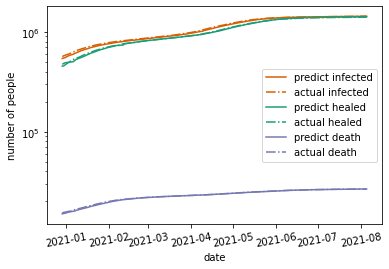

In [100]:
import tikzplotlib

x = last_update_pydatetime[VAL_IDX+input_steps+output_steps:]

confirmed_color=(217/256,95/256,2/256)
plt.plot(x, predict_1_day_ahead_observable[:,0], label ='predict infected', color=confirmed_color )
plt.plot(x, true_test_value[3:,0], '-.', label ='actual infected', color =confirmed_color)
healed_color=(27/256,158/256,119/256)
plt.plot(x, predict_1_day_ahead_observable[:,1], label ='predict healed', color=healed_color)
plt.plot(x, true_test_value[3:,1], '-.', label ='actual healed', color=healed_color)
plt.xlabel("date")
plt.ylabel("number of people")
death_color=(117/256,112/236,179/256)
plt.plot(x, predict_1_day_ahead_observable[:,2], label ='predict death', color=death_color)
plt.plot(x, true_test_value[3:,2], '-.', label ='actual death', color=death_color)
plt.yscale('log')
plt.legend()
plt.xticks(rotation=10)
tikzplotlib.save("sidarthe.tikz")
plt.show()

In [101]:
mean_squared_error(predict_1_day_ahead_observable[:,0], true_test_value[3:,0], squared=False)

16410.667439629255

In [102]:
mean_squared_error(predict_1_day_ahead_observable[:,1], true_test_value[3:,1], squared=False)

10267.87672877038

In [103]:
mean_squared_error(predict_1_day_ahead_observable[:,2], true_test_value[3:,2], squared=False)

168.56754911020718

In [118]:
list(model.named_parameters())

[('y0',
  Parameter containing:
  tensor([0.5062, 0.4243, 0.0100, 0.0100, 0.0455], requires_grad=True)),
 ('α',
  Parameter containing:
  tensor([0.4497], requires_grad=True)),
 ('β',
  Parameter containing:
  tensor([0.3382], requires_grad=True)),
 ('γ',
  Parameter containing:
  tensor([0.4148], requires_grad=True)),
 ('δ',
  Parameter containing:
  tensor([0.1402], requires_grad=True)),
 ('ε',
  Parameter containing:
  tensor([0.1708], requires_grad=True)),
 ('θ',
  Parameter containing:
  tensor([0.4218], requires_grad=True)),
 ('ζ',
  Parameter containing:
  tensor([0.0863], requires_grad=True)),
 ('η',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('μ',
  Parameter containing:
  tensor([0.1974], requires_grad=True)),
 ('ν',
  Parameter containing:
  tensor([0.1000], requires_grad=True)),
 ('τ',
  Parameter containing:
  tensor([0.1013], requires_grad=True)),
 ('λ',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('κ',
  Parameter containing:
